In [29]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            gross_revenue,
            fiscal_year,
            ownership,
            tot_days,
            tot_days_title_v,
            tot_days_title_xviii,
            tot_days_title_xix,
            num_beds,
            tot_bed_days_avail,
            snf_num_beds,
            snf_admis_tot,
            snf_avg_stay_len_title_tot,
            snf_days_total,
            tot_discharge_tot,
            snf_discharge_tot,
            tot_salaries,
            overhead_nonsalary_costs,
            cash,
            acct_rec,
            acct_payable,
            tot_current_assets,
            tot_fixed_assets,
            tot_assets,
            tot_liabilities,
            contract_labor,
            total_operating_expense,
            loc_type,
            current_ratio,
            deficiency_score,
            overall_rating,
            county_ssa,
            zip,
            resfamcouncil,
            sprinkler_status,
            chow_last_12mos,
            fine_cnt,
            fine_tot,
            tot_penlty_cnt,
            state,
            survey_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            bedcert,
            region,
            snf_size

        FROM Master
        ORDER BY prov_id;
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

# Assuming NA contract_labor means the Nursing home does have contract_labor
df[['contract_labor']] = df[['contract_labor']].fillna(0)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Extract target variable (y) and independent variables (X)
y = df_encoded['gross_revenue']
X = df_encoded.iloc[:, 2:]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define XGBoost regressor and set hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.085,
    max_depth=3,
    min_child_weight=1,
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='rmse',
    objective='reg:tweedie',
    gamma=0.15,              # Regularization parameter
    reg_alpha=0.19,           # L1 regularization
    reg_lambda=0.09          # L2 regularization
)

# Train the model with progress printout and early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
)

[0]	validation_0-rmse:11504075.10307	validation_1-rmse:11629682.10448
[1]	validation_0-rmse:11504073.86953	validation_1-rmse:11629680.87913
[2]	validation_0-rmse:11504072.20268	validation_1-rmse:11629679.21231
[3]	validation_0-rmse:11504070.01755	validation_1-rmse:11629677.04448
[4]	validation_0-rmse:11504067.73928	validation_1-rmse:11629674.78975
[5]	validation_0-rmse:11504065.32861	validation_1-rmse:11629672.38542
[6]	validation_0-rmse:11504061.90395	validation_1-rmse:11629668.99151
[7]	validation_0-rmse:11504057.93826	validation_1-rmse:11629665.05622
[8]	validation_0-rmse:11504053.38896	validation_1-rmse:11629660.52834
[9]	validation_0-rmse:11504048.16546	validation_1-rmse:11629655.34076
[10]	validation_0-rmse:11504041.41729	validation_1-rmse:11629648.63284
[11]	validation_0-rmse:11504033.91049	validation_1-rmse:11629641.17982
[12]	validation_0-rmse:11504024.79478	validation_1-rmse:11629632.11886
[13]	validation_0-rmse:11504013.96440	validation_1-rmse:11629621.36131
[14]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.15, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.085, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [32]:
import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, max_error, mean_absolute_error, mean_squared_error, explained_variance_score

# Predict on test set
y_pred = xgb_model.predict(X_test)

# R² Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Median Absolute Error
mdae = median_absolute_error(y_test, y_pred)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Root Mean Squared Error: ${:.2f}".format(rmse))
print("Median Absolute Error: ${:.2f}".format(mdae))
print("Mean Absolute Error: ${:.2f}".format(mae))
print("Mean Absolute Percentage Error: {:.2f}%".format(mape))
print("R² Score (Coefficient of Determination): {:.5f}".format(r2))

Root Mean Squared Error: $2290929.15
Median Absolute Error: $756957.25
Mean Absolute Error: $1266514.49
Mean Absolute Percentage Error: 12.24%
R² Score (Coefficient of Determination): 0.85790


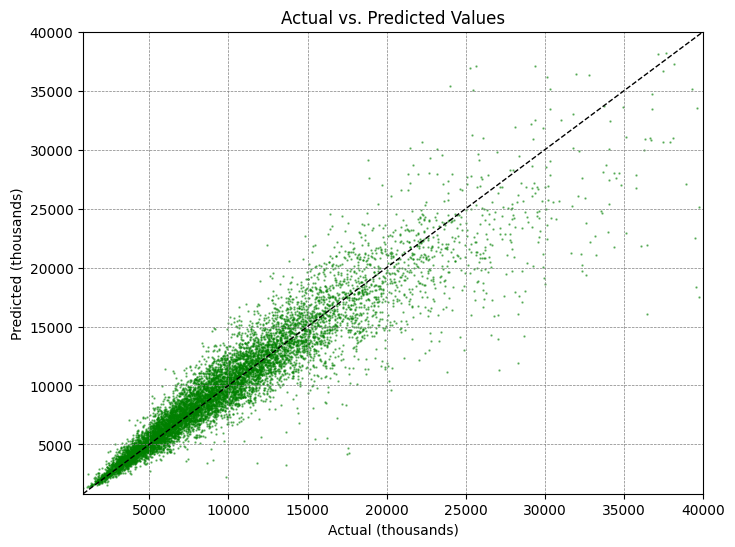

In [33]:
import matplotlib.pyplot as plt

# Convert values to thousands
y_test_thousands = y_test / 1000
y_pred_thousands = y_pred / 1000

plt.figure(figsize=(8, 6))
plt.scatter(y_test_thousands, y_pred_thousands, color='green', alpha=0.5, s=0.5)
plt.plot([y_test_thousands.min(), y_test_thousands.max()], [y_test_thousands.min(), y_test_thousands.max()], 'k--', lw=1)  # Plot the diagonal line
plt.xlabel('Actual (thousands)')
plt.ylabel('Predicted (thousands)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the actual values
plt.xlim(left=y_test_thousands.min(), right=40000)
plt.ylim(bottom=y_test_thousands.min(), top=40000)

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

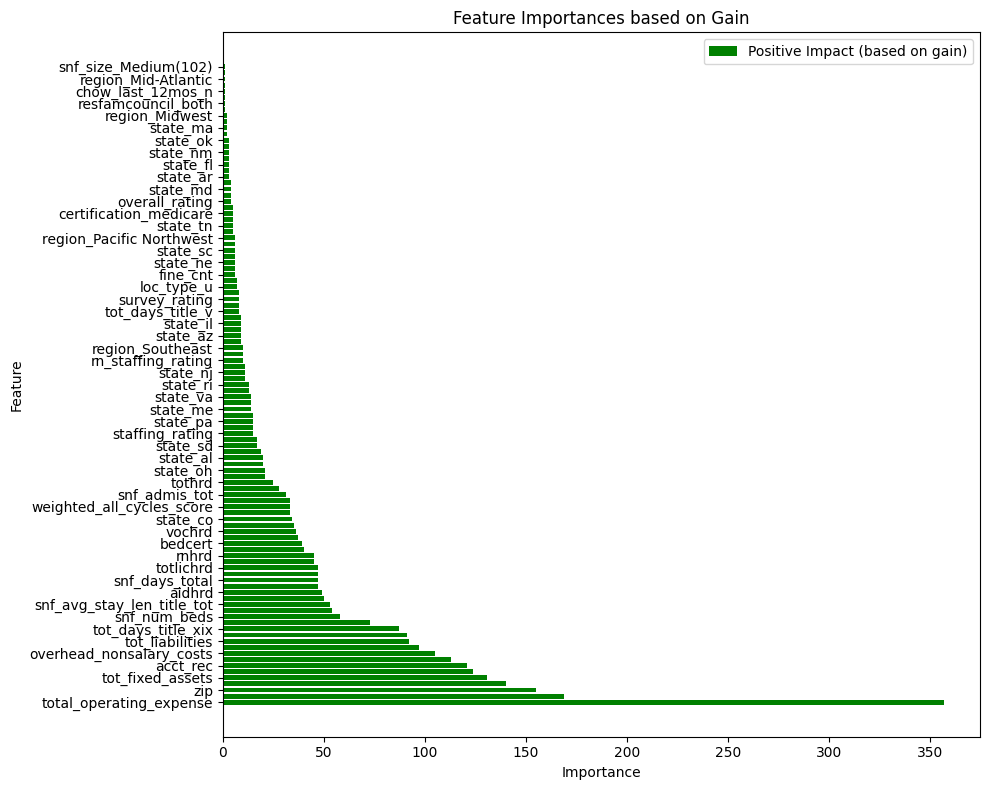

In [34]:
# Get feature importances based on gain
feature_importances_gain = xgb_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance_gain = sorted(feature_importances_gain.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances_gain = dict(sorted_feature_importance_gain)

# Extract feature names and importances
positive_features_gain, positive_importances_gain = zip(*positive_importances_gain.items())

# Plot positive importances based on gain
plt.figure(figsize=(10, 8))
plt.barh(positive_features_gain, positive_importances_gain, color='green', label='Positive Impact (based on gain)')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances based on Gain')
plt.legend()

# Increase spacing between y-axis ticks by skipping every other tick
plt.yticks(range(0, len(positive_features_gain), 2), positive_features_gain[::2])  # Skip every other tick

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [38]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['median_absolute_percentage_error'])
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['median_absolute_percentage_error'], label='Train')
plt.plot(x_axis, results['validation_1']['median_absolute_percentage_error'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.show()

KeyError: 'median_absolute_percentage_error'